forked from main iowa_redistricting on march 28

manually implementing algorithm described in Chen and Rodden (2013)

Shapefile dataframes used in this notebook

shapefile_iowa: MGGG stuff merged with census stuff

shapef_ia_proj: projected to UTM so we can run distance calculations on it

shapef_ia_fordistricting: 99 rows for each county, ready for initial allocation; made from deep copy of shapef_ia_proj

shapef_counties_for_realloc: made from a deep copy from shapef_ia_fordistricting; this has a num_switches column and a district column populated with the district assignment from the initial allocation

shapef_ia_initialdistricting: came from _fordistricting, went through the districting (step 1/2) process, and is now 4 rows
	as of Sept 18, not modified further for step 3/district balancing

shapef_ia_redist: this is a deep copy of shapef_ia_initialdistricting with a few dropped columns. This df is used for making new districts

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
from PIL import Image, ImageOps
from plotnine import (ggplot, aes, geom_map, geom_text, geom_label, 
                      ggtitle, element_blank, element_rect, 
                      scale_fill_manual, theme_minimal, theme) 
from pulp import (LpProblem, LpMinimize, LpVariable, lpSum, 
                  PULP_CBC_CMD, GLPK_CMD, LpStatus, value) 


import math         ##for math.sqrt
import random       #for random selection of district to start with

# Prepping the census and geopandas dataframes

## Importing data

In [2]:
#census.csv is data from Secretary of State's office.
census_df=pd.read_csv('census.csv')
census_df['COUNTYFP10']=census_df['COUNTYFP10'].astype(str).str.pad(3,fillchar='0')
census_df.head()

,county_id,county,population,COUNTYFP10,latitude,longitude
0,0,Adair,7496,001,41.328528,-94.478164
1,1,Adams,3704,003,41.021656,-94.696906
2,2,Allamakee,14061,005,43.274964,-91.382751
3,3,Appanoose,12317,007,40.744683,-92.870345
4,4,Audubon,5674,009,41.679178,-94.904312


In [3]:
#imports county shapefiles from MGGG
shapefile_iowa = gpd.read_file('IA_counties/IA_counties.shp').sort_values('NAME10',ignore_index=True)
shapefile_iowa.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 57 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   STATEFP10   99 non-null     object  
 1   COUNTYFP10  99 non-null     object  
 2   GEOID10     99 non-null     int64   
 3   NAME10      99 non-null     object  
 4   NAMELSAD10  99 non-null     object  
 5   ALAND10     99 non-null     int64   
 6   AWATER10    99 non-null     int64   
 7   INTPTLAT10  99 non-null     object  
 8   INTPTLON10  99 non-null     object  
 9   TOTPOP      99 non-null     int64   
 10  NH_WHITE    99 non-null     int64   
 11  NH_BLACK    99 non-null     int64   
 12  NH_AMIN     99 non-null     int64   
 13  NH_ASIAN    99 non-null     int64   
 14  NH_NHPI     99 non-null     int64   
 15  NH_OTHER    99 non-null     int64   
 16  NH_2MORE    99 non-null     int64   
 17  HISP        99 non-null     int64   
 18  H_WHITE     99 non-null     int64   
 19  H_

In [4]:
## Merging ONLY 2020 population numbers and county_id from census df into shapefile_iowa
shapefile_iowa = shapefile_iowa.merge(census_df[['COUNTYFP10','population','county_id']], on='COUNTYFP10').copy()

In [5]:
county_populations = np.array(census_df['population'])
state_population = sum(county_populations)
n_counties = 99
n_districts = 4

## Projecting shapefile to UTM 15N

In [6]:
#First, show the current coordinate reference system
shapefile_iowa.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [7]:
#Then project the shapefiles to UTM 15N
shapef_ia_proj = shapefile_iowa.to_crs(epsg=26915)

shapef_ia_proj.crs

<Derived Projected CRS: EPSG:26915>
Name: NAD83 / UTM zone 15N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 96°W and 90°W - onshore and offshore. Canada - Manitoba; Nunavut; Ontario. United States (USA) - Arkansas; Illinois; Iowa; Kansas; Louisiana; Michigan; Minnesota; Mississippi; Missouri; Nebraska; Oklahoma; Tennessee; Texas; Wisconsin.
- bounds: (-96.0, 25.61, -90.0, 84.0)
Coordinate Operation:
- name: UTM zone 15N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [8]:
#checking out geopandas automatic distance calculation
shapef_ia_proj['geometry'].iloc[0].distance(shapef_ia_proj['geometry'].iloc[1])
# adair-to-adams distance is 0, so shortest distance, not centroid-to-centroid

0.0

## Merging pd and gpd dataframes and creating population heat map

In [9]:
## Merging ONLY lat/long + county id from census df into shapefile_iowa (since population and county_id are already there)
map_population_by_county_data = shapefile_iowa.merge(census_df[['COUNTYFP10','latitude','longitude']], on='COUNTYFP10').copy()

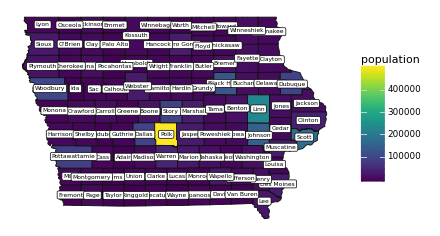

<ggplot: (375119281)>

In [10]:
map_population_by_county = (
    ggplot(map_population_by_county_data)
    + geom_map(aes(fill='population'))
    + geom_label(aes(x='longitude', y='latitude', 
                     label='NAME10',size=2), 
                 show_legend=False)
    + theme_minimal()
    + theme(axis_text_x=element_blank(),
            axis_text_y=element_blank(),
            axis_title_x=element_blank(),
            axis_title_y=element_blank(),
            axis_ticks=element_blank(),
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank()
           )
    )
map_population_by_county

# Creating distance matrix for Iowa counties

In [11]:
# adding/fixing columns with (projected) centroid locations 
shapef_ia_proj['xcentr_lon'] = shapef_ia_proj.centroid.x
shapef_ia_proj['ycentr_lat'] = shapef_ia_proj.centroid.y
#shapef_ia_proj.info()
# shapef_ia_proj['xcentr_lon'].iloc[1]

In [12]:
# cutting out other columns from the shapefile to be dissolved on

# 'TOTPOP' is the MGGG shapefile totpop (pre-2020), so removing
# also removing: the un-projected 'INTPTLAT10' and 'INTPTLON10'
#      and 'NAMELSAD10', the 2 word name
#      and all demographic/voting data
#      and (later on): also removing ALAND and AWATER, since they just get messy with merges and dissolves

districting_columns = ['COUNTYFP10', 'NAME10', 'geometry', 
       'population', 'county_id', 'xcentr_lon', 'ycentr_lat']

#make a new shapefile, which will be merged/dissolved on in the process of making districts
shapef_ia_fordistricting = shapef_ia_proj[districting_columns].copy()

#add column of county indices (which will get concatenated, as county_id_string)
shapef_ia_fordistricting['county_id_string'] = shapef_ia_fordistricting['county_id']
shapef_ia_fordistricting['county_id_string'] = shapef_ia_fordistricting['county_id_string'].astype(str).str.pad(2,fillchar='0')

#add column of county indices (which will become district indices)
shapef_ia_fordistricting['temp_district'] = shapef_ia_fordistricting.index

shapef_ia_fordistricting.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 99 entries, 0 to 98
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   COUNTYFP10        99 non-null     object  
 1   NAME10            99 non-null     object  
 2   geometry          99 non-null     geometry
 3   population        99 non-null     int64   
 4   county_id         99 non-null     int64   
 5   xcentr_lon        99 non-null     float64 
 6   ycentr_lat        99 non-null     float64 
 7   county_id_string  99 non-null     object  
 8   temp_district     99 non-null     int64   
dtypes: float64(2), geometry(1), int64(3), object(3)
memory usage: 7.7+ KB


# Nearest-Neighbor district-building model

* To start, we have 99 districts, 1 for each county.
* Randomly select a district (single county at the moment!) to start with.
* Join it to its nearest neighbor (using centroid measurement of distance).
    * Make new shapefile with those two counties dissolved together (and calc new centroids/distances)
    * Now we have 98 districts. Repeat until 4 left.

This procedure preserves compactness well, but has no population controls.
After we're down to 4 districts, we will then swap counties between districts until populations stabilize.


## Building-block functions (adjacency matrix + distance matrix)

In [13]:
# function for arbitrary adjacency matrix

def adj_mat_calc(temp_shapefile):
    curr_n_districts = len(temp_shapefile)
    adjac_mat = pd.DataFrame()

    for i in range(curr_n_districts):
        adjac_mat[i] = temp_shapefile.intersects(temp_shapefile.iloc[[i]].unary_union)
    
    adjac_mat = adjac_mat - np.identity(curr_n_districts)
    adjac_mat = adjac_mat.astype(int)

    #and/or boolean?
    # ia_adjac_matrix_bool = ia_adjac_matrix.astype(bool)

    return adjac_mat


In [14]:
#function: input is a shapefile with centroid columns, output is a distance matrix
def temp_distance_matrix(temp_shapefile):
    curr_n_districts = len(temp_shapefile)
    distance_mat = np.zeros((curr_n_districts,curr_n_districts))

    for i in range(curr_n_districts):
        for j in range(i):      #just do half the triangle, so indices from 0 to i-1
            x_dist = (temp_shapefile['xcentr_lon'].iloc[i] - temp_shapefile['xcentr_lon'].iloc[j])
            y_dist = (temp_shapefile['ycentr_lat'].iloc[i] - temp_shapefile['ycentr_lat'].iloc[j])
            distance_mat[i,j] = math.sqrt(x_dist**2 + y_dist**2)
            distance_mat[j,i] = math.sqrt(x_dist**2 + y_dist**2)

    return distance_mat


## full step 1/2 algorithm with iterability

In [15]:
shapef_ia_initialdistricting = shapef_ia_fordistricting.copy()


random.seed(2)      #for initial replicability while building.
#                    #if seed = 2, then this starts with the county with 7, Boone County.
        #first runthrough: 7 selected, 36 neighbor (merged is labeled as 7)
        #second runthrough: 11 selected, 33 is neighbor (merged is labeled as 11)

for i in range(95): ##### 95 iterations brings us from 99 districts to 4
    #how many districts are we working with this time?
    running_ndistricts = len(shapef_ia_initialdistricting)

    # pick out a district to work on on this iteration of the loop
    running_index = random.randint(0,running_ndistricts-1)        

    #find the temp_district associated with the running index
    #     the below was returning a slice of a dataframe, and not just the entry
    # running_temp_dist = shapef_ia_initialdistricting.loc[shapef_ia_initialdistricting.index == running_index, 'temp_district']
    running_temp_district = shapef_ia_initialdistricting['temp_district'].iloc[running_index]
    #     originally just called this for the print statement
         

    #set up adjacency and distance matrices
    running_adjmat = adj_mat_calc(shapef_ia_initialdistricting)
    running_distmat = temp_distance_matrix(shapef_ia_initialdistricting)

    print("On loop # %d (with %d districts remaining), we have selected index %d. \
    \n This corresponds to county id %s and temporary district # %d."   \
        % (i+1, running_ndistricts,running_index,   \
           shapef_ia_initialdistricting['county_id_string'].iloc[running_index], \
           running_temp_district) )
    
    #------find closest neighbor: could use cleaning up/making better
    distance_list = list(running_distmat[running_index])
    # distance_list.index(0)      # the index of the element with value 0 is 7

    # sorting is inefficient, maybe fix
    # https://stackoverflow.com/questions/26779618/python-find-second-smallest-number

    neighbor_dist = sorted(distance_list)[1]           #second smallest distance is nearest neighbor (since distance to self is zero)
    ##                                                    ### OR! check on adjacency matrix first!
    neighbor_index = distance_list.index(neighbor_dist)     #county 36 (Greene) is closest to county 7 (Boone)
    
    # the temp_district number associated with the neighbor_index
    # the below was having iiiiissues
    #     neighbor_temp_dist = shapef_ia_initialdistricting.loc[shapef_ia_initialdistricting.index ==neighbor_index, 'temp_district']
    neighbor_temp_district= shapef_ia_initialdistricting['temp_district'].iloc[neighbor_index]
    #   this doesn't really get used except to print? but running_temp_district is super important for re-indexing

    print("The nearest neighbor index is %d, representing county id %s and temporary district # %d." \
        % (neighbor_index,   \
           shapef_ia_initialdistricting['county_id_string'].iloc[neighbor_index],\
           neighbor_temp_district) )
    #---------end finding closest neightbor

    # re-index the neighbor county to be in the first county's district
    shapef_ia_initialdistricting.loc[shapef_ia_initialdistricting.index == neighbor_index, 'temp_district'] = running_temp_district      


    # dissolve shapefile based on temp_district to combine the two counties
    #aggregate remaining columns by summing them

    # arguments for aggfunc: https://geopandas.org/en/stable/docs/user_guide/aggregation_with_dissolve.html
    shapef_ia_initialdistricting = shapef_ia_initialdistricting.dissolve(
        by="temp_district",
        aggfunc = {
            "COUNTYFP10": "sum",    #sum = concatenation here b/c string
            "NAME10": "count",      #kind of dummy: will be 2 only for most-recently-merged district
            "population": "sum",
            "county_id": "sum",     #should be actual sum here, kind of dummy
            "xcentr_lon": "first",  #dummy, since we'll recalculate
            "ycentr_lat": "first",
            "county_id_string": "sum", #sum = concatenation here b/c string
            "temp_district": "first"
        }
    )

    # update centroid lat/longs!
    shapef_ia_initialdistricting['xcentr_lon'] = shapef_ia_initialdistricting.centroid.x
    shapef_ia_initialdistricting['ycentr_lat'] = shapef_ia_initialdistricting.centroid.y

    #the dissolve process makes the temp_district column into the index of the dataframe
    #which then has issues when we iterate the process
    #so dump the index for a dummy one now
    shapef_ia_initialdistricting = shapef_ia_initialdistricting.reset_index(drop=True)


    print("Districts remaining:", len(shapef_ia_initialdistricting))  #print how many districts are left

# shapef_ia_initialdistricting = shapef_ia_initialdistricting.copy()


On loop # 1 (with 99 districts remaining), we have selected index 7.     
 This corresponds to county id 07 and temporary district # 7.
The nearest neighbor index is 36, representing county id 36 and temporary district # 36.
Districts remaining: 98
On loop # 2 (with 98 districts remaining), we have selected index 11.     
 This corresponds to county id 11 and temporary district # 11.
The nearest neighbor index is 33, representing county id 33 and temporary district # 33.
Districts remaining: 97
On loop # 3 (with 97 districts remaining), we have selected index 10.     
 This corresponds to county id 10 and temporary district # 10.
The nearest neighbor index is 20, representing county id 20 and temporary district # 20.
Districts remaining: 96
On loop # 4 (with 96 districts remaining), we have selected index 46.     
 This corresponds to county id 49 and temporary district # 49.
The nearest neighbor index is 60, representing county id 63 and temporary district # 63.
Districts remaining: 9

In [16]:
# these were used to check which counties (via IDs and FIPs) were in each district
# list(shapef_ia_initialdistricting["county_id_string"])
# list(shapef_ia_initialdistricting["COUNTYFP10"])

### plot maps of new districts

In [17]:
shapef_ia_initialdistricting['combined_label'] = shapef_ia_initialdistricting['population'].astype(str)  + str(' (dist ') + shapef_ia_initialdistricting['temp_district'].astype(str) + str (')')
shapef_ia_initialdistricting['combined_label']
# shapef_ia_initialdistricting.info()

0     133122 (dist 42)
1     412348 (dist 61)
2     385133 (dist 74)
3    2259766 (dist 94)
Name: combined_label, dtype: object

In [18]:
#label_field: 'population', 'temp_district', 'combined_label'
def map_merged_districts(new_shapefile,label_field):
    map_population_by_district = (
        ggplot(new_shapefile)
        + geom_map(aes(fill='population'))
        + geom_label(aes(x='xcentr_lon', y='ycentr_lat', 
                        label=(label_field),size=2), 
                    show_legend=False)
        + theme_minimal()
        + theme(axis_text_x=element_blank(),
                axis_text_y=element_blank(),
                axis_title_x=element_blank(),
                axis_title_y=element_blank(),
                axis_ticks=element_blank(),
                panel_grid_major=element_blank(),
                panel_grid_minor=element_blank()
            )
        )

    return map_population_by_district

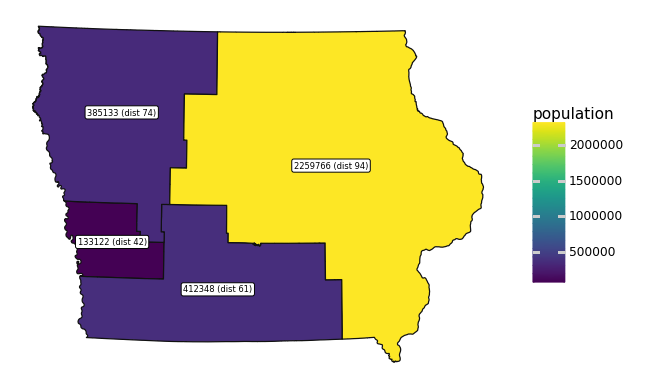

<ggplot: (375118939)>

In [19]:
map_merged_districts(shapef_ia_initialdistricting,'combined_label')

In [20]:
shapef_ia_initialdistricting[['population','temp_district']]

,population,temp_district
0,133122,42
1,412348,61
2,385133,74
3,2259766,94


# Begin step 3: redistributing counties until population is within bounds

## Helper Functions

In [21]:
# helper function: input is a shapefile with 'population' 
# column. output is a full matrix with SIGNED
# population differences between attributes
# row - col
# positive value in row i column j means that pop(i) > pop(j)
# negative value in row i column j means that pop(i) < pop(j)
def pop_diff_matrix(temp_shapefile):
    curr_n_districts = len(temp_shapefile)
    pop_diff_mat = np.zeros((curr_n_districts,curr_n_districts))

    for i in range(curr_n_districts):
        for j in range(curr_n_districts):   
            pop_diff_mat[i,j] = temp_shapefile['population'].iloc[i] - temp_shapefile['population'].iloc[j]
    
    return pop_diff_mat


## helper function: given a dataframe of movable counties
# and another dataframe of the district they're going to
# make a list of relative distances
def calculate_rel_dist(border_counties,new_district):
    n_border_counties = len(border_counties)
    distance_list = np.zeros((n_border_counties,3))

    for i in range(n_border_counties):
        oldx_dist = border_counties['xcentr_lon_2'].iloc[i] - border_counties['xcentr_lon_1'].iloc[i]
        oldy_dist = border_counties['ycentr_lat_2'].iloc[i] - border_counties['ycentr_lat_1'].iloc[i]

        # old_dist
        distance_list[i,0] = math.sqrt(oldx_dist**2 + oldy_dist**2)

        newx_dist = border_counties['xcentr_lon_2'].iloc[i] - new_district['xcentr_lon'].iloc[0]
        newy_dist = border_counties['ycentr_lat_2'].iloc[i] - new_district['ycentr_lat'].iloc[0]

        # new_dist
        distance_list[i,1] = math.sqrt(newx_dist**2 + newy_dist**2)

        ## relative_distance: old - new
        # we'll move the county with highest relative distance
        distance_list[i,2] = distance_list[i,0] - distance_list[i,1]

    #we only need relative distances, not the component parts
    #so we could just make an n x 1 list instead of n x 3
    rel_dist = distance_list[:,2]
    return rel_dist

In [25]:
#-----------module to find neighboring districts with the greatest population difference---------------------
def neighbor_popdiff_fun(df):
    #adjacencey matrix for 4 districts
    adj_mat_array = adj_mat_calc(df).to_numpy()   

    #SIGNED population difference array
    # row minus col
    # positive value in row i column j means that pop(i) > pop(j)
    # negative value in row i column j means that pop(i) < pop(j)
    pop_diff_array = pop_diff_matrix(df)
    # zero out any pairs that aren't adjacent
    # for numpy arrays, "*" is piecewise multiplication
    neighbor_popdiff = adj_mat_array * pop_diff_array

    return neighbor_popdiff

In [36]:
#Identify the border counties between the two districts with biggest population difference
#return a dataframe with the border counties with a column of relative distances between the big and small districts
def border_counties_fun(shapef_ia_redist, list_of_districts, list_of_counties):
    neighbor_popdiff=neighbor_popdiff_fun(shapef_ia_redist)
    #maxpopdiff_loc is an ordered pair giving the location of the
    #maximum value within neighbor_popdiff. Note!! Indexed on (0,n-1)!
    maxpopdiff_loc = np.unravel_index(np.argmax(neighbor_popdiff, axis=None),   neighbor_popdiff.shape)

    #population threshold for a border county that can get moved:
    #  half of the difference between the two neighboring districts we're adjusting
    #  if dist 1 has pop 700k and dist 2 has pop 1mil, then max size that can be moved
    #  from dist 2 to dist 1 is 300k
    pop_limit_switch=.5*neighbor_popdiff.max()

    #big district is the *row*, so first element of ordered pair
    big_dist_index = maxpopdiff_loc[0]
    #small district is the *column*, so second element of ordered pair
    small_dist_index = maxpopdiff_loc[1]

    # big district geodataframe
    # should match shapef_ia_redist.iloc[[big_dist_index]]
    #    (though with diff indexing, which matters in distance helper fxn)
    # bigdist = list_of_districts[big_dist_index].copy()
    smalldist = list_of_districts[small_dist_index].copy()

    #----------find which county will be swapped from "bigdist" to  "smalldist"----------------------
    #from the list of 4 dataframes (each of diff districts)
    #we call the dataframe of the big district
    bigdist_counties = list_of_counties[big_dist_index].copy()

    #dataframe of counties in the Big district which are 
    #adjacent to the Small district so which we might move
    #(possible to be point neighbors and have issues -
    #should be okay with D criterion, though)
    #reset index so it is (0,n-1), instead of sparse indexing based on where the county     was within the district
    #we retain the original county id in 'county_id'
    bigdist_movable = bigdist_counties.loc[bigdist_counties.intersects(smalldist.   unary_union)].reset_index(drop=True).copy()

    # adding column to bigdist_movable with relative distances
    bigdist_movable['rel_distance'] = calculate_rel_dist(bigdist_movable,smalldist)
    return bigdist_movable, pop_limit_switch

In [27]:
# switch_func helper function
# input is a dataframe with potentially movable counties (and a count of switches)
# output is a county to switch: first priority: below threshold of switches (and population)
#    Then, max relative distance of what's left
def switch_func(dataframe,switches_threshold):
    dataframe_sorted = dataframe.sort_values('rel_distance',ascending=False).copy()
    #gives the column index for num_switches 
    switch_index=dataframe_sorted.columns.get_loc('num_switches')
    rel_distance_index = dataframe_sorted.columns.get_loc('rel_distance')
    pop_limit_switch=border_counties_fun(shapef_ia_redist, list_of_districts, list_of_counties)[1]
    # min_switches=min(dataframe['num_switches'])
    for i in range(dataframe_sorted.shape[0]):
        if (dataframe_sorted.iloc[i]['num_switches'] <= switches_threshold) & (dataframe_sorted.iloc[i]['population_2']<pop_limit_switch):
            # dataframe_sorted.iloc[i,switch_index]+=1
            # movingcounty_index=i
            return dataframe_sorted.iloc[i]['county_id']
            break
        # else:
        #     print('This county does not satisfy the num_switch and population threshold criteria')

#identifies the threshhold for the number of switches in the border counties
def switch_threshold_fun(bigdist_movable):
    # array with all switch counts from the movable county list
    num_switches_array = np.array(bigdist_movable['num_switches'])

    # max and min values from the array
    max_switches = max(num_switches_array)
    min_switches = min(num_switches_array)
    # our chosen threshold for switches: halfway between max and min (floor)
    switches_threshold = min_switches + np.ceil((max_switches-min_switches)/2)
    return switches_threshold

## Main part of reallocation

In [22]:
# adding switch_count to county shapefile which we will be using
shapef_counties_for_realloc = shapef_ia_fordistricting.copy()

# make a column with num_switches
shapef_counties_for_realloc['num_switches'] = np.zeros(shapef_counties_for_realloc.shape[0],dtype=int)

In [23]:
#9/13 note: update names of shapef_ia_redist to make sure it's clear what is in the rows.
# drop: 'NAME10' (was just "2" for most-recently-merged attribute)
#       'COUNTYFP10' (concatenated FIPS code)
#       'county_id'  (summed county ids) 
#       'temp_district'  (1 arbitrary "root" county code) 
shapef_ia_redist = shapef_ia_initialdistricting.drop(columns=['NAME10', 'COUNTYFP10','county_id','temp_district']).copy()

# make a column with a district #, 1-4
shapef_ia_redist['district_label'] = shapef_ia_redist.index + 1

# Making separate geodataframes for each district (one district/attribute in each).
list_of_districts=[]
for i in range(4):
    list_of_districts.append(shapef_ia_redist.iloc[[i]].reset_index(drop=True))

#the identity overlay takes district n and splits it up by all counties
# which fall inside it (from main, un-districted shapefile)
#keep_geom_type=True   discards boundary points and lines from counties which only border the district
#resulting dataframe columns: _1 stuff comes from parent (whole district)
#                             _2 stuff comes from specific county
list_of_counties=[]
for i in range(4):
    list_of_counties.append(list_of_districts[i].overlay(shapef_counties_for_realloc,how='identity',keep_geom_type=True))

#this records the district number each county is assigned to in the first pass
shapef_counties_for_realloc['DISTRICT']=''
for i in range(99):
    for j in range(4):
        # if i<j:
        if shapef_counties_for_realloc.iloc[i]['COUNTYFP10'] in list_of_counties[j]['COUNTYFP10'].tolist():
            shapef_counties_for_realloc.loc[i,'DISTRICT']=j+1
# shapef_counties_for_realloc

In [29]:
bigdist_movable=border_counties_fun(shapef_ia_redist, list_of_districts, list_of_counties)[0]
# bigdist_movable
switches_threshold=switch_threshold_fun(bigdist_movable)
switches_threshold
# What county should be switched? Humboldt! (FIPS 091)
movingcounty_index=switch_func(bigdist_movable, switches_threshold)
print(movingcounty_index)
# label this as movingcounty_index for later

45


In [38]:
shapef_counties_for_realloc.loc[shapef_counties_for_realloc['county_id']==movingcounty_index]

,COUNTYFP10,NAME10,geometry,population,county_id,xcentr_lon,ycentr_lat,county_id_string,temp_district,num_switches,DISTRICT
45,091,Humboldt,"POLYGON ((401417.632 4751324.379, 402363.225 4...",9597,45,401247.022382,4.736698e+06,45,45,0,4


##       New portions in September '23

Below is June stuff and September updates of June stuff

Pseudo code for initial allocation and reallocation:

1. Initial allocation (complete)
    - Prep gpdf for initial allocation
    - Create the dataframe with all 99 counties and their district assignments (shapef_ia_fordistricting)
    - Treat all 99 counties as its own district
    - Pick an initial random seed county and merge with its nearest neighbor
    - Repeat above step until there are only 4 districts left
    - Get dataframes for each district and convert to gpdf
2. Process data from initial allocation
    - Compute adjacency matrices for districts and population differences between districts (modules complete)
    - Create dataframes for 99 counties with district information and districts with shapefile information (complete)
3. Redistributing districts to balance out population
    - Identify border counties for the pair of adjacent districts that have the greatest population difference (module complete)
    - Identify county amongst border counties that satisfies mininum relative distance, population, and number of switches criteria (modules complete)
    - Switch the county from the larger to the smaller district and update its district label in the shapef_ia_fordistricting dataframe
    - Update populations in the districts and rerun steps 4-7 until populations of each district falls within specified size requirements

In [65]:
# Game plan to move FIPS 091 (as proof of concept):
#      -use switch_fun to identify border county to move
#     -bigdist_movable.loc[bigdist_movable['COUNTYFP10']==switch_func(bigdist_movable)]
# -move FPS 091, update its district number
# -write a function to update all district sub-dataframes

In [33]:
list(list_of_counties[0]['county_id'])

[14, 42, 77, 82]

In [ ]:
#this cell reworks the cell copied from the 4/4/23 commit using updated variables and helper functions

for i in range(1):

    #add in portions that find the small dist, big dist, relative dist, etc
    #in order to run switch_func on the border counties (aka bigdist_movable)
    movingcounty_index=switch_func(bigdist_movable)

    #list of lists of county IDs in each district
    district_countylist=[]
    for j in range(n_districts):
        district_countylist[j]=list(list_of_counties[j]['county_id'])

    #list of a dataframes
    #each district's GDF gets updated after a county gets switched
    #still needs tweaking, currently borderline gibberish
    counties_in_dist_GDF=[]
    for k in range(4):
        counties_in_dist_GDF.append(list_of_districts[i].overlay(shapef_counties_for_realloc,how='identity',keep_geom_type=True))

## The cell immediately after this is from a 4/4/23 commit.

We have reworked roughly 60% of the the cell and have the updated portions above. We need to update the actual reallocation process with the new num_switches and population limit criteria.

https://github.com/stefaniegwangphd/ia-redistricting/blob/a649da434bc9678a45240cac0795fc0ddd693819/Iowa_contiguousdistricting.ipynb

In [66]:
# for i in range(70):

#     to be deleted soon
#     #the following 4 lines have been reworked. This is here to reference variables later on in the cell.
#     district1_countylist = countyid_lists[0].copy()       #.sort()   ......
#     district2_countylist = countyid_lists[1].copy()
#     district3_countylist = countyid_lists[2].copy()
#     district4_countylist = countyid_lists[3].copy()

#     #new geodataframes for each district with counties as attributes
#     #  (from main, un-districted shapefile, according to county_id_string content
#     #   or since we now have a column with districts, no need to do the .isin here?
#     #   could instead just do =shapef_ia_step3.loc[shapef_ia_step3['district_number'] == 1]
#     dist1_counties_GDF = shapef_ia_step3.loc[shapef_ia_step3['county_id_string'].isin(district1_countylist)]
#     dist2_counties_GDF = shapef_ia_step3.loc[shapef_ia_step3['county_id_string'].isin(district2_countylist)]
#     dist3_counties_GDF = shapef_ia_step3.loc[shapef_ia_step3['county_id_string'].isin(district3_countylist)]
#     dist4_counties_GDF = shapef_ia_step3.loc[shapef_ia_step3['county_id_string'].isin(district4_countylist)]
#     list_of_countyGDFs = [dist1_counties_GDF,dist2_counties_GDF,dist3_counties_GDF,dist4_counties_GDF]


#     print("Iteration %d. The big neighbor district is district %d (%d counties). The small neighbor district is district %d (%d counties)." \
#         % (i+1,            
#            big_dist_index + 1,   
#            len(countyid_lists[big_dist_index]),       
#            small_dist_index + 1, 
#            len(countyid_lists[small_dist_index]) 
#            ) )

#     print("The county id to move is %s." \
#     % (county_id_str_to_move)           #could use int instead of str if we wanted
#     )

#     #-----------swap county between districts and update for re-run ---------------------------

#     #remove the county id from the list of counties in the big district:
#     countyid_lists[big_dist_index].remove(county_id_str_to_move)

#     #add the county id to the list of counties in the small district:
#     countyid_lists[small_dist_index].append(county_id_str_to_move)

#     #update the district in the shapefile (+1 since districts are [1,4] not [0,3]):
#     #           could use regular county_id or county_id_string
#     shapef_ia_step3.loc[shapef_ia_step3['county_id_string']==county_id_str_to_move, 'district_number'] = small_dist_index +1

#     #update the dissolved shapefile:
#     shapef_step3_dissolved = dissolve_by_district(shapef_ia_step3)

#     print("After shifting, the big neighbor district has %d counties. The small neighbor district has %d counties." \
#     % (len(countyid_lists[big_dist_index]), len(countyid_lists[small_dist_index]))  )

#     #-------------------------------   district populations: --------------
#     # shapef_step3_dissolved['population']
#     curr_maxpop = max(shapef_step3_dissolved['population'])
#     curr_minpop = min(shapef_step3_dissolved['population'])

#     diff1 = curr_maxpop - district_maximum           # goal is for these to both be negative
#     diff2 = district_minimum - curr_minpop

#     print("Our largest district has %d too many people. Our smallest district has %d too few people." \
#           %
#           (diff1,diff2)
#           )

#     if ((diff1 < 0) and (diff2 < 0)):
#         break

### visualizations

In [67]:
#input: shapefile of counties within a particular district 
#   (after undergoing identity overlay)
#   label_field options: 'NAME10', 'population_2', 'county_id', 'county_id_string_2', etc
def map_unmerged_districts(new_shapefile,label_field):
    map_counties_by_district = (
        ggplot(new_shapefile)
        + geom_map(aes(fill='population_2'))
        + geom_label(aes(x='xcentr_lon_2', y='ycentr_lat_2', 
                        label=label_field,size=2), 
                    show_legend=False)
        + theme_minimal()
        + theme(axis_text_x=element_blank(),
                axis_text_y=element_blank(),
                axis_title_x=element_blank(),
                axis_title_y=element_blank(),
                axis_ticks=element_blank(),
                panel_grid_major=element_blank(),
                panel_grid_minor=element_blank()
            )
        )

    return map_counties_by_district

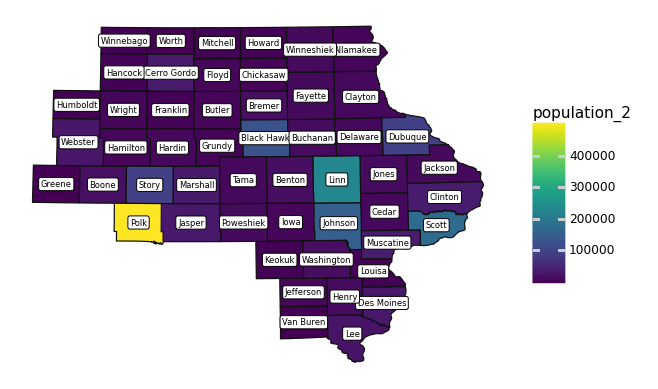

<ggplot: (360208129)>

In [68]:
#this gives an example of output of map_unmerged_districts
map_unmerged_districts(list_of_counties[3],'NAME10')

## future steps

From Chen's paper:

(3a) Among all pairs of districts that border one another, identify the pair with the greatest disparity in district population. Within this pair,
let us denote the more populated district as $i$ and the less populated district as $j$.

(3b) Identify the set of all precincts currently within district $i$ that could be reassigned to district $j$ without violating the geographic contiguity of either district $i$ or $j$.

(3c) For each precinct $p$ satisfying the criterion in step 3b, define $D_p$ as precinct $p$’s geographic distance to the centroid of district $i$, minus
precinct $p$’s distance to the centroid of district $j$.

(3d) Among the set of precincts satisfying the criteria in step 3b, select the precinct, $p$, with the highest value of Dp . Reassign this precinct from
district $i$ to district $j$.

## District size bounds

In [69]:
ideal_district_size=state_population/n_districts
tolerance=.01
district_maximum=int(ideal_district_size*(1+tolerance))
district_minimum=int(ideal_district_size*(1-tolerance))